<h1 style="color:yellow;">Concurrent Data - Deep Learning</h1>

# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import time
import sys
sys.path.append(os.path.abspath(".."))

from utils import print_evaluation_metrics, print_memory_usage, clean_database, \
    analyze_correlations, perform_voting_feature_selection, \
    log_metrics, plot_individual_metrics
from preprocess import preprocessing

pd.set_option('display.max_columns', None)
preprocessing_dir = os.path.join('figures','preprocessing')
results_dir = os.path.join('figures', 'results')
evaluation_dir = os.path.join('figures','evaluation charts')
db_path = os.path.join('..', 'data', 'datasets', '5G NIDD', 'Combined.csv')

# Data cleaning and splitting

[Preprocessing] Dropping artifact columns: ['Unnamed: 0']
Original shape: (1215890, 51)
Shape after removing duplicates: (1215869, 51)

[Dataset Info] Attack Type Distribution (Counts):
Attack Type
Benign            477716
UDPFlood          457340
HTTPFlood         140812
SlowrateDoS        73124
TCPConnectScan     20052
SYNScan            20043
UDPScan            15906
SYNFlood            9721
ICMPFlood           1155
Name: count, dtype: int64
[Preprocessing] Final feature set (40): ['Dur', 'Mean', 'Sum', 'Min', 'Max', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz', 'dMeanPktSz', 'Load', 'SrcLoad', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'pLoss', 'SrcGap', 'DstGap', 'Rate', 'SrcRate', 'DstRate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck', 'AckDat']

[Verification] Class distribution (normalized) across splits:
                Original     Train       Val      Test
Attac

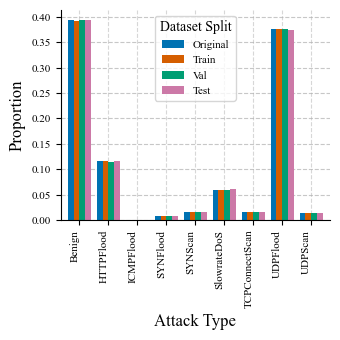

[Memory] Before GC: 1519.31 MB
[Memory] After GC: 1291.64 MB
[Preprocessing] Applying PowerTransformer (Yeo-Johnson) to fix skewness and standardize data...
[Visualization] Plotting top 3 skewed features before transformation: ['DstGap', 'SrcGap', 'DstRate']


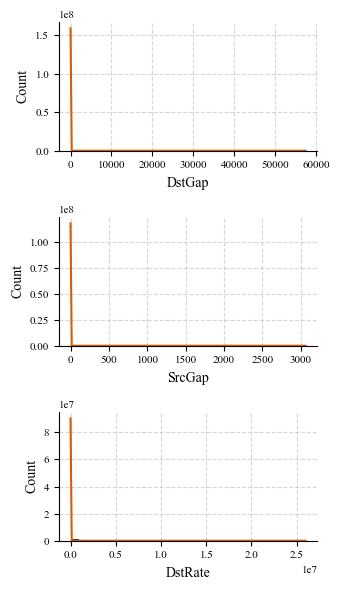

[Visualization] Plotting top 3 skewed features after transformation


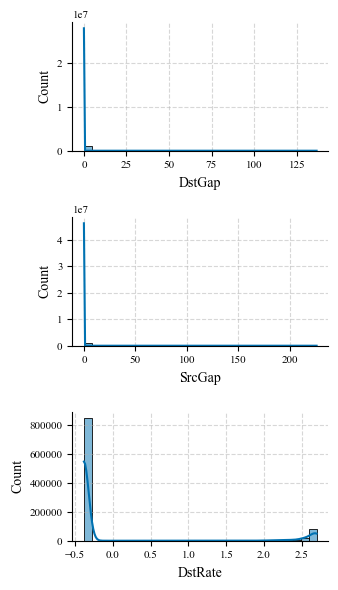

<class 'pandas.core.frame.DataFrame'>
Index: 972695 entries, 285273 to 583254
Data columns (total 40 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dur         972695 non-null  float32
 1   Mean        972695 non-null  float32
 2   Sum         972695 non-null  float32
 3   Min         972695 non-null  float32
 4   Max         972695 non-null  float32
 5   Proto       972695 non-null  float32
 6   sTos        972695 non-null  float32
 7   dTos        972695 non-null  float32
 8   sDSb        972695 non-null  float32
 9   dDSb        972695 non-null  float32
 10  sTtl        972695 non-null  float32
 11  dTtl        972695 non-null  float32
 12  Cause       972695 non-null  float32
 13  TotPkts     972695 non-null  float32
 14  SrcPkts     972695 non-null  float32
 15  DstPkts     972695 non-null  float32
 16  TotBytes    972695 non-null  float32
 17  SrcBytes    972695 non-null  float32
 18  DstBytes    972695 non-null  float32
 19  Of

In [2]:
X_train, X_val, X_test, y_train, y_val, y_test, output_encoder = clean_database(db_path, preprocessing_dir, do_scale=False, fix_skewness=True)
# Force garbage collection to clear the large raw dataframe from memory immediately
gc.collect()
print_memory_usage("Notebook - After clean_database")

# Feature Selection

## Correlations

### Analyze correlation between featrues

In [ ]:
high_corr_features = analyze_correlations(X_train, threshold=0.95)

### Drop correlated featuers

In [ ]:
# Use inplace=True to avoid creating a copy of the dataframe in memory
X_train.drop(columns=high_corr_features, inplace=True)
X_val.drop(columns=high_corr_features, inplace=True)
X_test.drop(columns=high_corr_features, inplace=True)
print(f"Dropped {len(high_corr_features)} correlated features.")

gc.collect()
print_memory_usage("Notebook - After Dropping Correlated Features")

In [ ]:
# Print the number of remaining features
print(f"Remaining features count: {X_train.shape[1]}")

# Print the list of remaining feature names
print("Remaining features list:")
print(X_train.columns.tolist())

# Arguments

In [6]:
version = 'ML'
sampling_method = 'smote'
plot_distributions = True
model_results= []

# Compare the results of all methods

[Memory] Notebook - Before Feature Selection: 1805.72 MB

[Comparison] Using full training data (972695 samples) for feature selection.

Comparing Feature Selection Methods

--- Filter Method: pearson ---

[Filter] Starting PEARSON Feature Selection to select top 25 features...
[Filter] Completed in 0.07 seconds.
[Filter] Selected Features: ['Dur', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'Cause', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'Rate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck']
   -> Validation Accuracy: 0.9791

--- Filter Method: anova ---

[Filter] Starting ANOVA Feature Selection to select top 25 features...
[Filter] Completed in 0.12 seconds.
[Filter] Selected Features: ['Dur', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'Rate', 'State', 'S

/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


[Embedded] Completed in 28.99 seconds.
[Embedded] Selected Features: ['Dur', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Loss', 'SrcLoss', 'Rate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck']
   -> Validation Accuracy: 0.9790

--- Embedded Method: ridge ---

[Embedded] Starting RIDGE Feature Selection to select top 25 features...


/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


[Embedded] Completed in 53.94 seconds.
[Embedded] Selected Features: ['Dur', 'Proto', 'sTos', 'sDSb', 'dDSb', 'sTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'Rate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck']
   -> Validation Accuracy: 0.9791

--- Embedded Method: elastic_net ---

[Embedded] Starting ELASTIC_NET Feature Selection to select top 25 features...


/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


[Embedded] Completed in 30.11 seconds.
[Embedded] Selected Features: ['Dur', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Loss', 'SrcLoss', 'Rate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck']
   -> Validation Accuracy: 0.9790

--- Embedded Method: rf ---

[Embedded] Starting RF Feature Selection to select top 25 features...
[Embedded] Completed in 7.60 seconds.
[Embedded] Selected Features: ['Dur', 'Proto', 'sTos', 'dTos', 'dDSb', 'sTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'Rate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck']
   -> Validation Accuracy: 0.9791

--- Embedded Method: gradient_boosting ---

[Embedded] Starting GRADIENT_BOOSTING Feature Selection to select top 25 features...
[Embedded] Completed in 896.84 seconds.
[Embedded] Selected Features: ['Dur', 

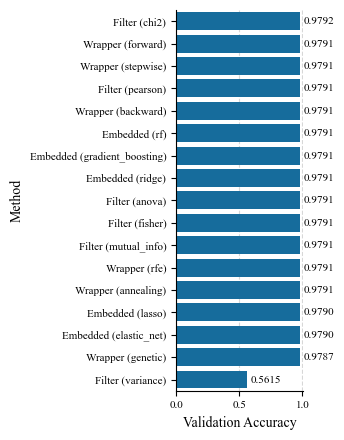


[Debugging] Feature Selection Verification

Rank 1: Filter (chi2) (Acc: 0.9792)
  Features: ['Dur', 'Proto', 'sTos', 'dTos', 'dDSb', 'sTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'DstGap', 'Rate', 'State', 'SrcWin', 'TcpRtt', 'SynAck']

Rank 2: Wrapper (forward) (Acc: 0.9791)
  Features: ['Proto', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'SrcGap', 'DstGap', 'Rate', 'State', 'SrcWin', 'DstWin', 'TcpRtt']

Rank 3: Wrapper (stepwise) (Acc: 0.9791)
  Features: ['Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'SrcGap', 'DstGap', 'Rate', 'State', 'SrcWin', 'DstWin', 'TcpRtt']

Rank 4: Filter (pearson) (Acc: 0.9791)
  Features: ['Dur', 'P

In [ ]:
print_memory_usage("Notebook - Before Feature Selection")

# Optimization: 'sample_size=50000' significantly speeds up Wrapper methods (like RFE) 
# which are extremely slow on the full dataset (200k+ rows).
selected_features, comparison_results = perform_voting_feature_selection(
    X_train, y_train, X_val, y_val, 
    n_features=25, 
    sample_size=None,  # <--- Performance Fix
    top_k=3,
    file_path=preprocessing_dir,
    version=version
)
gc.collect()
print_memory_usage("Notebook - After Feature Selection")

# LDA
# X_train, X_val, X_test = perform_lda_reduction(X_train, y_train, X_val, X_test)

# Autoencoder
# X_train, X_val, X_test = perform_autoencoder_reduction(
#     X_train, X_val, X_test, 
#     encoding_dim=20, 
#     epochs=20, 
#     device=device
# )

## Filter the dataframes to include only selected columns

In [8]:
# Overwrite your dataframes to keep ONLY the selected columns
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

# Preprocessing

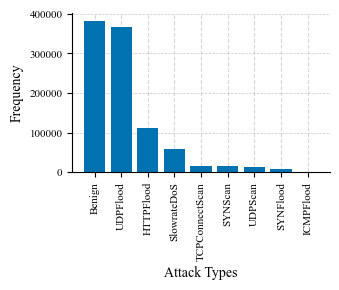

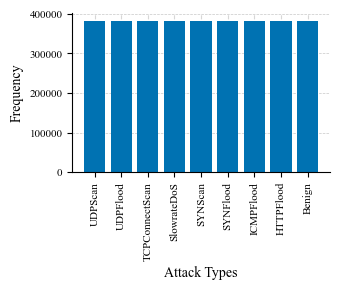


[Preprocessing] Final dataset sizes (after smote):
  - Training samples: 3438171
  - Validation samples: 121587
  - Test samples: 121587
[Memory] Notebook - Ready for Training: 1485.30 MB


In [9]:
X_train_processed, X_val_scaled, X_test_scaled, y_resampled, y_val, y_test = preprocessing(X_train, X_val, X_test, y_train, y_val, y_test, output_encoder, preprocessing_dir, version, sampling_method, plot_distributions)
print_memory_usage("Notebook - Ready for Training")

In [23]:
# 1. Define the directory to save the processed data
# You can adjust the path name as needed
save_dir = os.path.join('..', 'data frames', 'ML','25 Features')

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: {save_dir}")

print(f"Saving data to: {os.path.abspath(save_dir)}")

# 2. Save the feature matrices (X)
# These are already numpy arrays (float32) from your preprocessing function
np.save(os.path.join(save_dir, 'X_train_processed.npy'), X_train_processed)
np.save(os.path.join(save_dir, 'X_val_scaled.npy'), X_val_scaled)
np.save(os.path.join(save_dir, 'X_test_scaled.npy'), X_test_scaled)

# 3. Save the target vectors (y)
np.save(os.path.join(save_dir, 'y_resampled.npy'), y_resampled)
np.save(os.path.join(save_dir, 'y_val.npy'), y_val)
np.save(os.path.join(save_dir, 'y_test.npy'), y_test)

# 4. Save the label encoder classes
# This is crucial if you want to map predictions back to original names (e.g., 'Benign', 'DDoS') later
np.save(os.path.join(save_dir, 'label_classes.npy'), output_encoder.classes_)

print("All datasets saved successfully.")

Created directory: ../data frames/ML/25 Features
Saving data to: /Users/hemaali/Desktop/Master Degree Project/data frames/ML/25 Features
All datasets saved successfully.


# Machine Learning

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB


## Logistic Regression

In [11]:
linear_model = LogisticRegression(solver='saga', max_iter=1000, n_jobs=-1, random_state=42)

start_time = time.time()
linear_model.fit(X_train_processed, y_resampled)
training_time = time.time() - start_time

start_time = time.time()
y_pred_lr = linear_model.predict(X_val_scaled)
prediction_time = time.time() - start_time


/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Logistic Regression Evaluation:
Accuracy: 0.94612088
Precision: 0.94920723
Recall: 0.94612088
F1 Score: 0.94699221
Training Time: 58.3201 seconds
Prediction Time: 0.0050 seconds
latency per sample: 0.00000004 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.95389517 0.93279103 0.94322507     47821
     HTTPFlood  0.97394983 0.93642072 0.95481665     14014
     ICMPFlood  0.30964467 1.00000000 0.47286822       122
      SYNFlood  0.99206349 0.98039216 0.98619329      1020
       SYNScan  0.99449174 0.98904382 0.99176030      2008
   SlowrateDoS  0.81927569 0.96271139 0.88522083      7214
TCPConnectScan  0.88158487 0.99441341 0.93460621      1969
      UDPFlood  0.95778138 0.95374435 0.95575860     45789
       UDPScan  0.98008449 0.99631902 0.98813508      1630

      accuracy                      0.94612088    121587
     macro avg  0.87364126 0.97175955 0.90139825    121587
  weighted avg  0.94920723 0.94612088 0.94699221    1

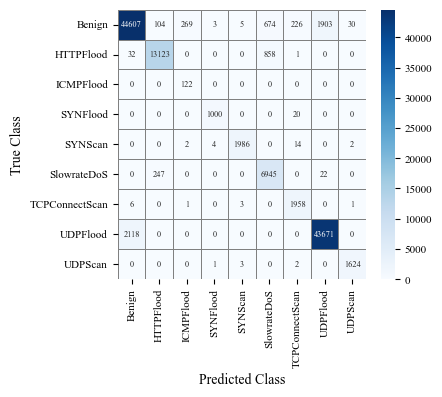

In [12]:
# arguments for evaluation function
results_file_name = 'logistic_regression_results.txt'
cm_title = 'Logistic Regression Confusion Matrix'

print("Logistic Regression Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val, y_pred_lr, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'logistic_regression', accuracy, precision, recall, f1, training_time, prediction_time)

## Random Forest

In [13]:
rnd_forest = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs = -1)
start_time = time.time()
rnd_forest.fit(X_train_processed, y_resampled)
training_time = time.time() - start_time

start_time = time.time()
y_pred_rf = rnd_forest.predict(X_val_scaled)
prediction_time = time.time() - start_time

# arguments for evaluation function
model_type = 'random_forest'
results_file_name = 'random_forest_results.txt'
cm_title = 'Random Forest Confusion Matrix'

Evaluation:
Accuracy: 0.97916718
Precision: 0.97916742
Recall: 0.97916718
F1 Score: 0.97916721
Training Time: 24.3622 seconds
Prediction Time: 0.0937 seconds
latency per sample: 0.00000077 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.97445874 0.97413270 0.97429569     47821
     HTTPFlood  0.99750374 0.99800200 0.99775281     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  1.00000000 1.00000000 1.00000000      1020
       SYNScan  0.99850374 0.99701195 0.99775729      2008
   SlowrateDoS  0.99611489 0.99514832 0.99563137      7214
TCPConnectScan  0.99898322 0.99796851 0.99847561      1969
      UDPFlood  0.97299421 0.97333421 0.97316418     45789
       UDPScan  0.99571865 0.99877301 0.99724349      1630

      accuracy                      0.97916718    121587
     macro avg  0.99269747 0.99270786 0.99270227    121587
  weighted avg  0.97916742 0.97916718 0.97916721    121587



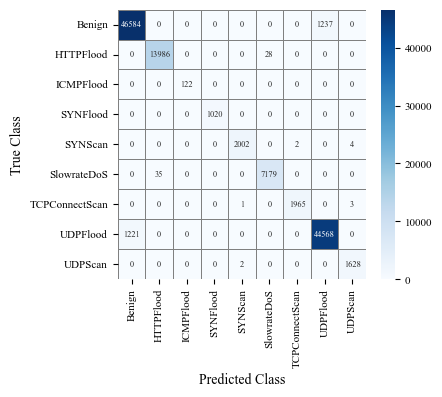

In [14]:
# arguments for evaluation function
results_file_name = 'random_forest_results.txt'
cm_title = 'Random Forest Confusion Matrix'

print("Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val, y_pred_rf, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'random_forest', accuracy, precision, recall, f1, training_time, prediction_time)

## XGBoost

In [15]:
# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(output_encoder.classes_), eval_metric='mlogloss')

# Train the model
start_time = time.time()
xgb_model.fit(X_train_processed, y_resampled)
training_time = time.time() - start_time

# Make predictions
start_time = time.time()
y_pred_xgb = xgb_model.predict(X_val_scaled)
prediction_time = time.time() - start_time

XGBoost Evaluation:
Accuracy: 0.98193063
Precision: 0.98244230
Recall: 0.98193063
F1 Score: 0.98193133
Training Time: 20.3409 seconds
Prediction Time: 0.1097 seconds
latency per sample: 0.00000090 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.99574810 0.95985027 0.97746971     47821
     HTTPFlood  0.99757420 0.99771657 0.99764538     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  0.99608993 0.99901961 0.99755262      1020
       SYNScan  0.99850000 0.99452191 0.99650699      2008
   SlowrateDoS  0.99556357 0.99542556 0.99549456      7214
TCPConnectScan  0.99847638 0.99847638 0.99847638      1969
      UDPFlood  0.95963040 0.99571950 0.97734191     45789
       UDPScan  0.99572127 0.99938650 0.99755052      1630

      accuracy                      0.98193063    121587
     macro avg  0.99303376 0.99334626 0.99311534    121587
  weighted avg  0.98244230 0.98193063 0.98193133    121587



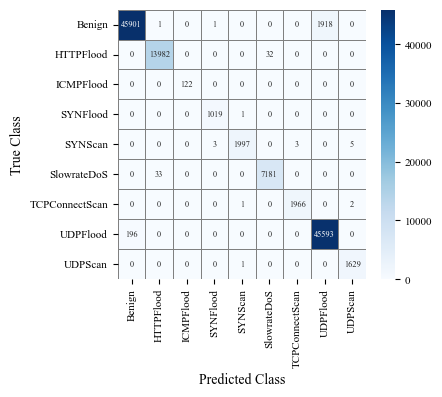

In [16]:
# arguments for evaluation function
results_file_name = 'xgboost_results.txt'
cm_title = 'XGBoost Confusion Matrix'

print("XGBoost Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val, y_pred_xgb, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'xgboost', accuracy, precision, recall, f1, training_time, prediction_time)

## Naive Bayes

In [17]:
# Create a Naive Bayes classifier
nb_model = GaussianNB()

# Train the model
start_time = time.time()
nb_model.fit(X_train_processed, y_resampled)
training_time = time.time() - start_time

# Make predictions
start_time = time.time()
y_pred_nb = nb_model.predict(X_val_scaled)
prediction_time = time.time() - start_time

Naive Bayes Evaluation:
Accuracy: 0.62732858
Precision: 0.80824831
Recall: 0.62732858
F1 Score: 0.57915529
Training Time: 0.3040 seconds
Prediction Time: 0.0257 seconds
latency per sample: 0.00000021 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.99144812 0.18182388 0.30729268     47821
     HTTPFlood  0.94493243 0.59875838 0.73303049     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  1.00000000 0.98627451 0.99308983      1020
       SYNScan  1.00000000 0.99352590 0.99675244      2008
   SlowrateDoS  0.54334792 0.92958137 0.68582532      7214
TCPConnectScan  0.99438489 0.98933469 0.99185336      1969
      UDPFlood  0.61982565 1.00000000 0.76529922     45789
       UDPScan  0.12841206 0.99570552 0.22748616      1630

      accuracy                      0.62732858    121587
     macro avg  0.80248345 0.85277825 0.74451439    121587
  weighted avg  0.80824831 0.62732858 0.57915529    121587



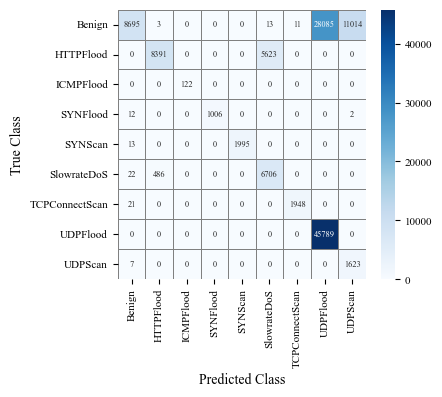

In [18]:
# arguments for evaluation function
results_file_name = 'naive_bayes_results.txt'
cm_title = 'Naive Bayes Confusion Matrix'

print("Naive Bayes Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val, y_pred_nb, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'naive_bayes', accuracy, precision, recall, f1, training_time, prediction_time)

## SVM

In [19]:
LSVC = LinearSVC(dual=False, random_state=42)

### Use One-vs-Rest classifier

In [20]:
ovr_classifier = OneVsRestClassifier(estimator=LSVC, n_jobs=-1)
start_time = time.time()
ovr_classifier.fit(X_train_processed, y_resampled)
training_time = time.time() - start_time

start_time = time.time()
y_pred_svm = ovr_classifier.predict(X_val_scaled)
prediction_time = time.time() - start_time

SVM Evaluation:
Accuracy: 0.96118006
Precision: 0.96144854
Recall: 0.96118006
F1 Score: 0.96120065
Training Time: 139.5394 seconds
Prediction Time: 0.0714 seconds
latency per sample: 0.00000059 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.96341749 0.94721984 0.95525001     47821
     HTTPFlood  0.97986002 0.97902098 0.97944032     14014
     ICMPFlood  0.97600000 1.00000000 0.98785425       122
      SYNFlood  0.91801802 0.99901961 0.95680751      1020
       SYNScan  0.99205955 0.99551793 0.99378573      2008
   SlowrateDoS  0.90936088 0.97629609 0.94164048      7214
TCPConnectScan  0.98891688 0.99695277 0.99291856      1969
      UDPFlood  0.95971007 0.96291686 0.96131079     45789
       UDPScan  0.97995140 0.98957055 0.98473748      1630

      accuracy                      0.96118006    121587
     macro avg  0.96303270 0.98294607 0.97263835    121587
  weighted avg  0.96144854 0.96118006 0.96120065    121587



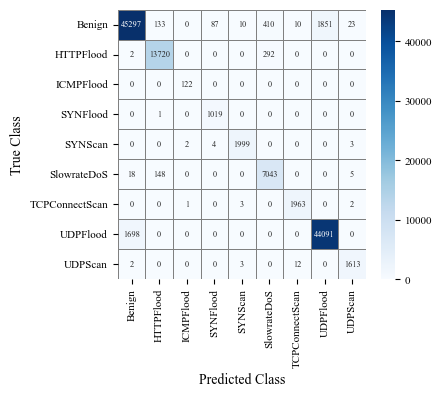

In [21]:
# arguments for evaluation function
results_file_name = 'svm_results.txt'
cm_title = 'Support Vector Machine Confusion Matrix'

print("SVM Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val, y_pred_svm, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'svm', accuracy, precision, recall, f1, training_time, prediction_time)

# Bar charts

Saved ML_comparison_accuracy.pdf


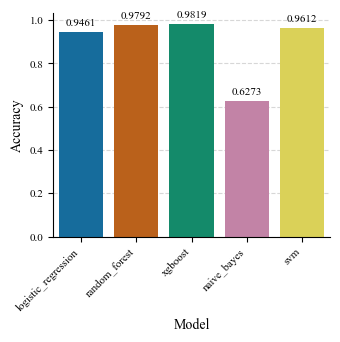

Saved ML_comparison_precision.pdf


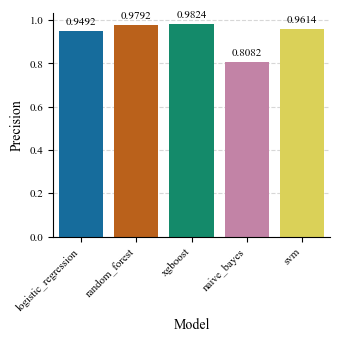

Saved ML_comparison_recall.pdf


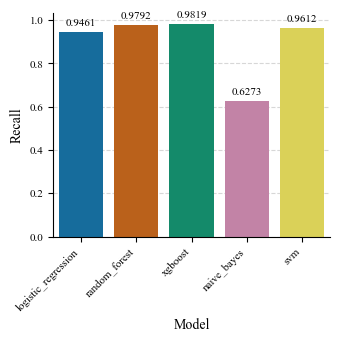

Saved ML_comparison_f1-score.pdf


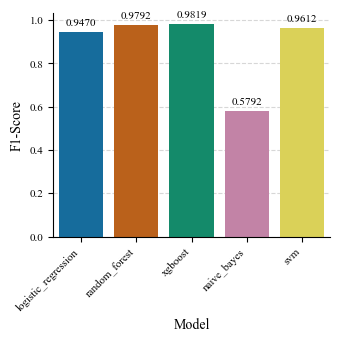

Saved ML_comparison_training_time_s.pdf


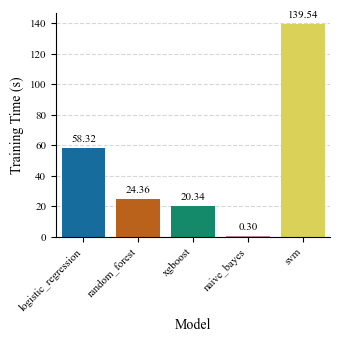

Saved ML_comparison_prediction_time_s.pdf


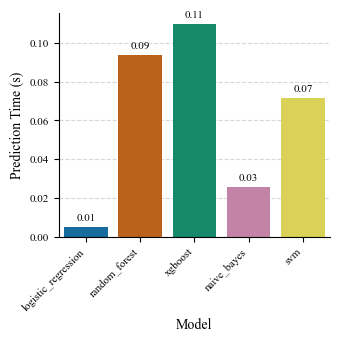

In [22]:
plot_individual_metrics(model_results, evaluation_dir, version)